<a href="https://colab.research.google.com/github/oliva2/EDA/blob/main/DL-SatelliteImagery/Satellite_Imagery_DeepLearning-Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code from Part 1 Exercise - Satellite Imagery Data Preparation



In [2]:
!pip install patchify

In [3]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [4]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [5]:
minmaxscaler = MinMaxScaler()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset_root_folder = '/content/drive/MyDrive'

In [8]:
dataset_name = "Semantic segmentation dataset"

In [9]:
image_patch_size = 256

In [10]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [11]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


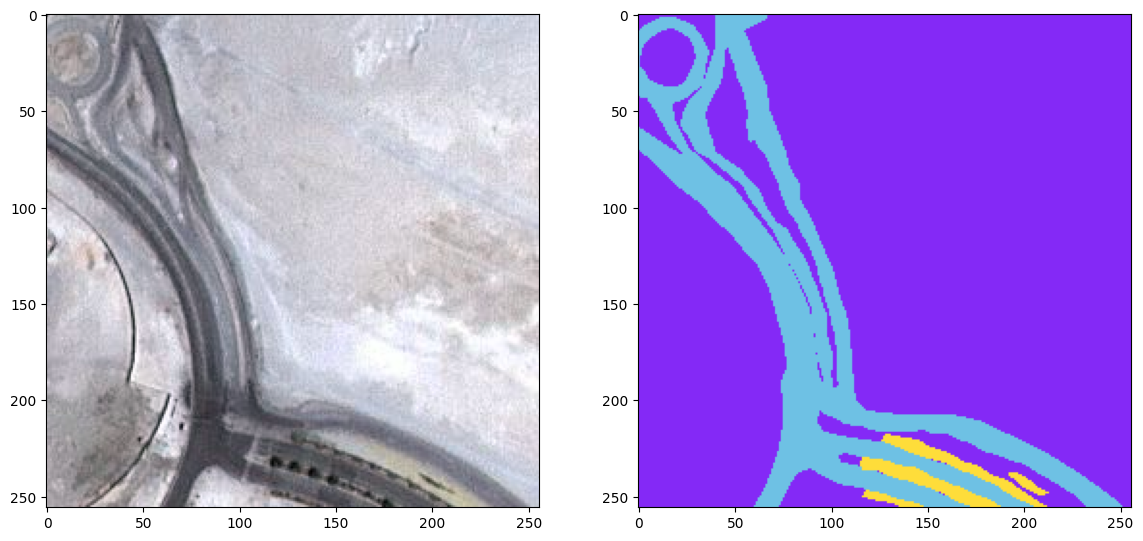

In [31]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [32]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [33]:
label = individual_patched_mask

In [34]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [35]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [36]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [37]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [38]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


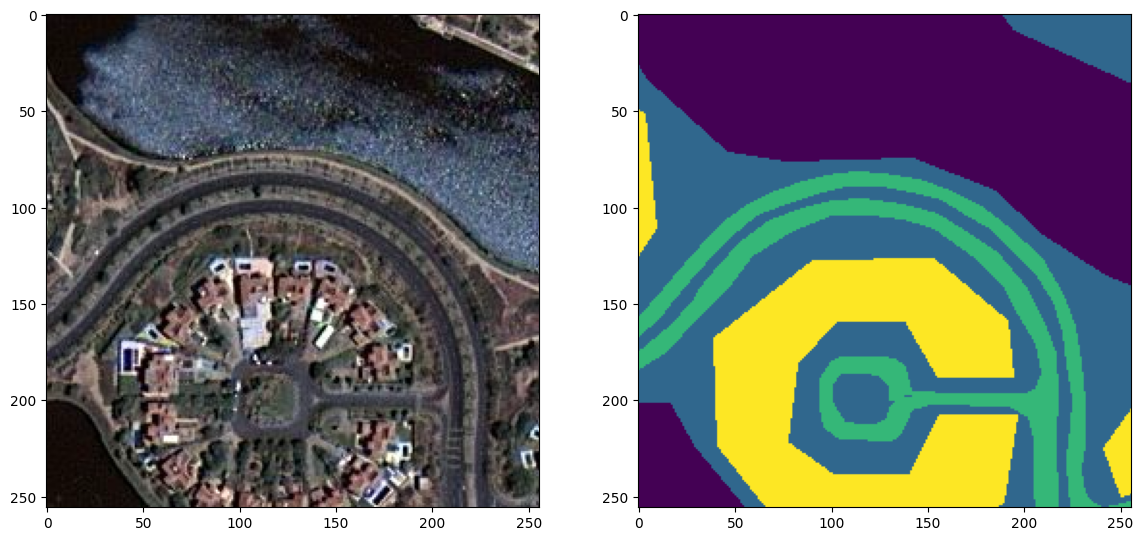

In [30]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [39]:
total_classes = len(np.unique(labels))

In [40]:
total_classes

6

In [41]:
from tensorflow.keras.utils import to_categorical

In [42]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [43]:
master_trianing_dataset = image_dataset

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [47]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [48]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Coding for Part 2: Deep Learning with Satellite Imagery Data

In [ ]:
#!pip install -U segmentation-models- up

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.4 MB/s 


In [49]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [50]:
from keras import backend as K

In [51]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = tf.keras.backend.flatten(y_true)
  y_pred_flatten = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [52]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [53]:
metrics = ["accuracy", jaccard_coef]

In [54]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [55]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [56]:
model = get_deep_learning_model()

In [57]:
# Please uncomment this line to get model confiuration
model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'cla

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [58]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [59]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [40]:
import segmentation_models as sm

In [60]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [61]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [62]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [63]:
import tensorflow as tf

In [64]:
tf.keras.backend.clear_session()


In [65]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [66]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
from tensorflow.keras import backend as K


In [68]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 55s 576ms/step - accuracy: 0.4749 - jaccard_coef: 0.2218 - loss: 1.0086 - val_accuracy: 0.6170 - val_jaccard_coef: 0.3606 - val_loss: 0.9903
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.6524 - jaccard_coef: 0.3734 - loss: 0.9806 - val_accuracy: 0.7081 - val_jaccard_coef: 0.4530 - val_loss: 0.9651
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7242 - jaccard_coef: 0.4685 - loss: 0.9603 - val_accuracy: 0.7328 - val_jaccard_coef: 0.4895 - val_loss: 0.9561
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.7436 - jaccard_coef: 0.5048 - loss: 0.9534 - val_accuracy: 0.7378 - val_jaccard_coef: 0.4989 - val_loss: 0.9569
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7565 - jaccard_coef: 0.5261 - loss: 0.9502 - val_accuracy: 0.7394 - val_jaccard_coef: 0.5146 - val_loss: 0.9547
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.7693 - jaccard_coef: 0.5521 - loss: 0.9446 

In [69]:
history_a = model_history

In [70]:
history_a.history

{'accuracy': [0.5510137677192688,
  0.6798515915870667,
  0.7270556688308716,
  0.7431460618972778,
  0.7593891024589539,
  0.7746322154998779,
  0.7848854064941406,
  0.7917527556419373,
  0.8047197461128235,
  0.8149044513702393],
 'jaccard_coef': [0.27459079027175903,
  0.40853261947631836,
  0.4745757579803467,
  0.5052094459533691,
  0.5298394560813904,
  0.5585290193557739,
  0.5742536783218384,
  0.5887811779975891,
  0.608656108379364,
  0.6275669932365417],
 'loss': [0.9995760917663574,
  0.9730433821678162,
  0.9588741064071655,
  0.9526822566986084,
  0.9480817317962646,
  0.9428647756576538,
  0.939098060131073,
  0.9364018440246582,
  0.9315162897109985,
  0.9278461933135986],
 'val_accuracy': [0.6170166730880737,
  0.7080566883087158,
  0.7328299880027771,
  0.7378280162811279,
  0.7394145727157593,
  0.7516078948974609,
  0.7372422814369202,
  0.7370653748512268,
  0.6984833478927612,
  0.7164543867111206],
 'val_jaccard_coef': [0.36062926054000854,
  0.4529511034488678,

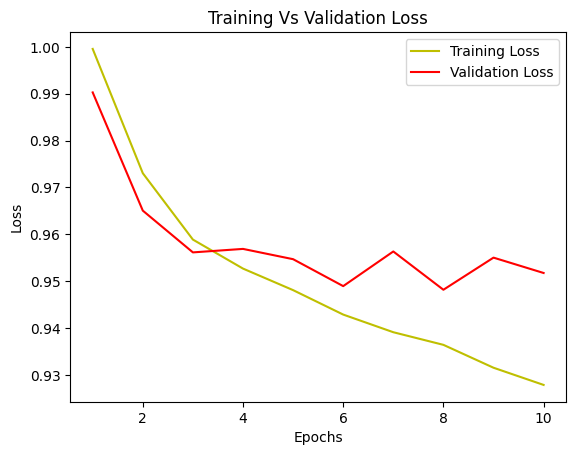

In [71]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

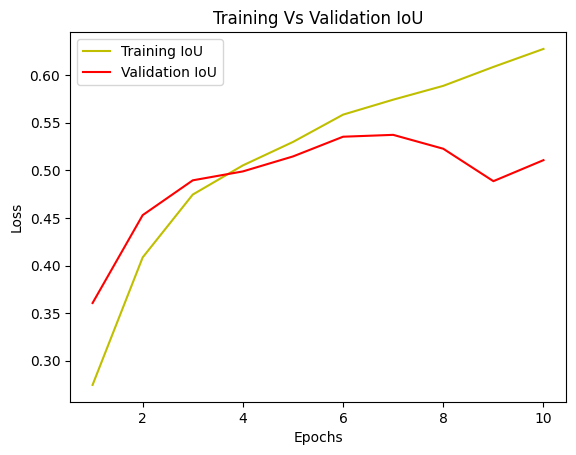

In [72]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [73]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 51}

In [74]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step


In [75]:
len(y_pred)

142

In [76]:
y_pred

array([[[[5.65916374e-02, 3.58433843e-01, 2.13023290e-01,
          1.85459748e-01, 1.31793797e-01, 5.46976812e-02],
         [2.02748440e-02, 4.93177801e-01, 1.58472732e-01,
          2.30446786e-01, 7.59091228e-02, 2.17186920e-02],
         [1.60118099e-02, 5.25319278e-01, 1.78901732e-01,
          1.78886861e-01, 8.43306556e-02, 1.65496133e-02],
         ...,
         [3.50825302e-02, 2.99819648e-01, 2.52927989e-01,
          1.11270688e-01, 2.87119865e-01, 1.37792556e-02],
         [4.02752198e-02, 3.09166104e-01, 2.35025883e-01,
          1.20298445e-01, 2.77462572e-01, 1.77717377e-02],
         [7.51943812e-02, 2.61511385e-01, 2.02891022e-01,
          1.62819639e-01, 2.44560108e-01, 5.30234538e-02]],

        [[3.19316834e-02, 4.94841695e-01, 1.98050231e-01,
          1.32624015e-01, 8.45906585e-02, 5.79617433e-02],
         [6.11403398e-03, 5.82728505e-01, 1.66232303e-01,
          1.69160202e-01, 5.50805926e-02, 2.06843801e-02],
         [4.80218325e-03, 5.77372909e-01, 2.1393

In [77]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [78]:
len(y_pred_argmax)

142

In [79]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 2, 1, 1],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 2],
        [4, 1, 1, ..., 2, 2, 2]],

       ...,

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [80]:
y_test_argmax = np.argmax(y_test, axis=3)

In [81]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [82]:
import random


In [104]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


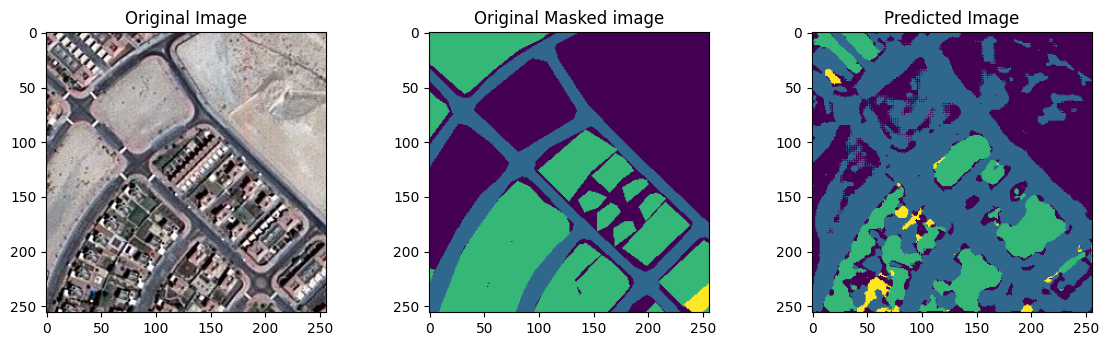

In [105]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [106]:
model.save("satellite_segmentation_full.h5")

In [107]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Jul  9 09:59 .
drwxr-xr-x 1 root root 4.0K Jul  9 09:39 ..
drwxr-xr-x 4 root root 4.0K Jul  7 19:54 .config
drwx------ 5 root root 4.0K Jul  9 09:51 drive
drwxr-xr-x 1 root root 4.0K Jul  7 19:55 sample_data
-rw-r--r-- 1 root root  23M Jul  9 09:59 satellite_segmentation_full.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


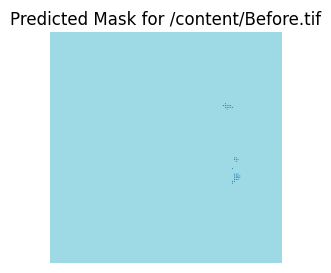

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


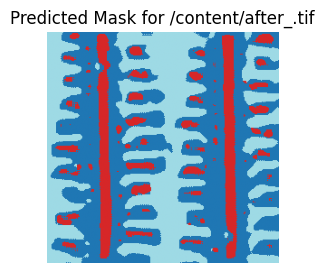

In [109]:
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def predict_and_show_mask(image_path):
    # Load and resize to model input size
    img = Image.open(image_path).resize((256, 256))
    img_array = img_to_array(img) / 255.0  # Normalize
    input_image = np.expand_dims(img_array, axis=0)  # (1, 256, 256, 3)

    # Predict mask
    pred_mask = model.predict(input_image)
    pred_class = np.argmax(pred_mask[0], axis=-1)  # (256, 256)

    # Show predicted mask
    plt.figure(figsize=(6, 3))
    plt.imshow(pred_class, cmap='tab20')
    plt.title(f"Predicted Mask for {image_path}")
    plt.axis('off')
    plt.show()

# Predict for both images
predict_and_show_mask("/content/Before.tif")
predict_and_show_mask("/content/after_.tif")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


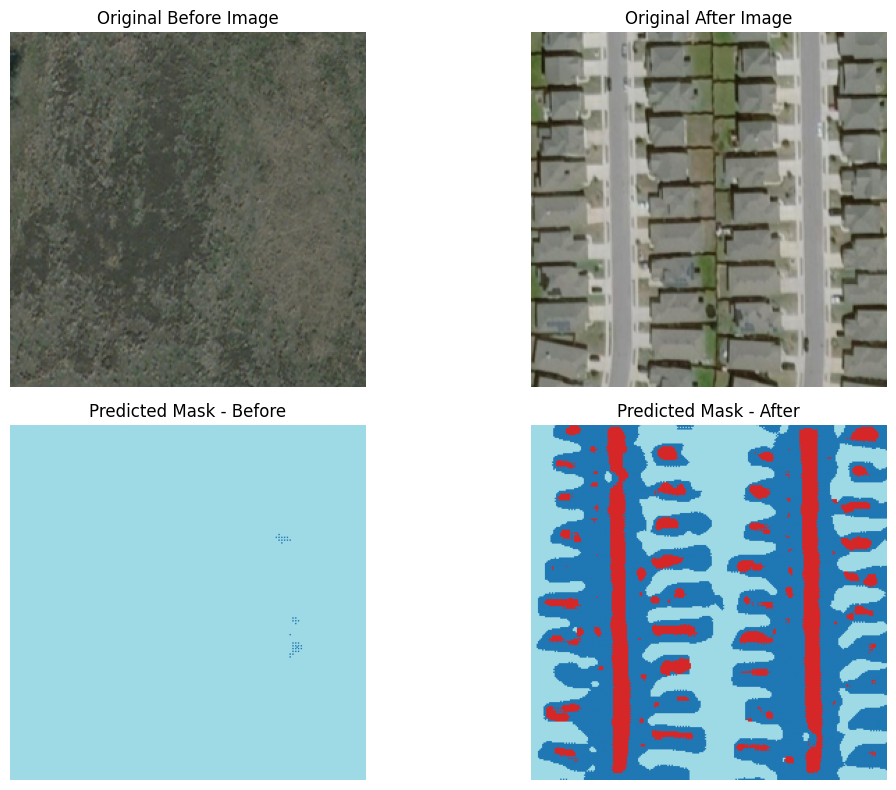


📍 Before Image
Road area: 0.00%
Building (build-up) area: 0.00%

📍 After Image
Road area: 14.00%
Building (build-up) area: 0.00%


In [113]:
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def calculate_area_percentages(predicted_mask, label):
    total_pixels = predicted_mask.size
    unique, counts = np.unique(predicted_mask, return_counts=True)
    class_counts = dict(zip(unique, counts))

    road_count = class_counts.get(2, 0)
    building_count = class_counts.get(3, 0)
    land_count = class_counts.get(1, 0)
    unlabeled_count = class_counts.get(5, 0)
    barren_count = land_count + unlabeled_count

    road_pct = (road_count / total_pixels) * 100
    building_pct = (building_count / total_pixels) * 100
    barren_pct = (barren_count / total_pixels) * 100

    print(f"\n📍 {label}")
    print(f"Road area: {road_pct:.2f}%")
    print(f"Building (build-up) area: {building_pct:.2f}%")
    #print(f"Barren land area (land + unlabeled): {barren_pct:.2f}%")

def load_image(image_path):
    img = Image.open(image_path).resize((256, 256))
    return np.array(img), img_to_array(img) / 255.0

def predict_mask(image_array):
    input_image = np.expand_dims(image_array, axis=0)
    pred_mask = model.predict(input_image)
    pred_class = np.argmax(pred_mask[0], axis=-1)
    return pred_class

# Load images
before_image_arr, before_input = load_image("/content/Before.tif")
after_image_arr, after_input = load_image("/content/after_.tif")

# Predict masks
before_mask = predict_mask(before_input)
after_mask = predict_mask(after_input)

# Plot 2x2: original before & after images + predicted masks
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(before_image_arr)
plt.title("Original Before Image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(after_image_arr)
plt.title("Original After Image")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(before_mask, cmap='tab20')
plt.title("Predicted Mask - Before")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(after_mask, cmap='tab20')
plt.title("Predicted Mask - After")
plt.axis('off')

plt.tight_layout()
plt.show()

# Area breakdown
calculate_area_percentages(before_mask, "Before Image")
calculate_area_percentages(after_mask, "After Image")


In [112]:
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image

def debug_prediction_classes(image_path):
    img = Image.open(image_path).resize((256, 256))
    img_array = img_to_array(img) / 255.0
    input_image = np.expand_dims(img_array, axis=0)

    pred_mask = model.predict(input_image)
    pred_class = np.argmax(pred_mask[0], axis=-1)

    unique_classes, class_counts = np.unique(pred_class, return_counts=True)
    class_info = dict(zip(unique_classes, class_counts))

    print(f"🧠 Predicted class distribution for {image_path}:")
    for cls, count in class_info.items():
        print(f"Class {cls}: {count} pixels")

debug_prediction_classes("/content/Before.tif")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🧠 Predicted class distribution for /content/Before.tif:
Class 1: 37 pixels
Class 4: 65499 pixels
